In [1]:
import pandas as pd
import numpy as np
risk_df = pd.read_csv('../pcms_hackathon_data/train/risk.csv')
care_df = pd.read_csv('../pcms_hackathon_data/train/care.csv')

print("risk_df shape:", risk_df.shape)
print("care_df shape:", care_df.shape)


risk_df shape: (8000, 2)
care_df shape: (425, 8)


In [2]:
care_df['last_care_dt'] = pd.to_datetime(care_df['last_care_dt'], errors='coerce')
care_df['next_care_dt'] = pd.to_datetime(care_df['next_care_dt'], errors='coerce')
care_df['has_next_care'] = care_df['next_care_dt'].notna().astype(int)

type_dummies = pd.get_dummies(care_df['msrmnt_type'], prefix='type')
subtype_dummies = pd.get_dummies(care_df['msrmnt_sub_type'], prefix='subtype')

care_binary = pd.concat([care_df[['patient_id']], type_dummies, subtype_dummies], axis=1)
care_binary = care_binary.groupby('patient_id').max().reset_index()

type_cols = [c for c in care_binary.columns if c.startswith('type_')]
subtype_cols = [c for c in care_binary.columns if c.startswith('subtype_')]

care_binary['count_msrmnt_type'] = care_binary[type_cols].sum(axis=1)
care_binary['count_msrmnt_sub_type'] = care_binary[subtype_cols].sum(axis=1)


care_agg = (
    care_df
    .groupby('patient_id')
    .agg({
        'care_id': 'count',                         
        'msrmnt_value': 'median',                   
        'last_care_dt': 'min',                      
        'next_care_dt': 'max',                      
        'care_gap_ind': lambda x: (x == 't').sum(), 
        'has_next_care': 'max'                      
    })
    .reset_index()
    .rename(columns={
        'care_id': 'num_care_events',
        'msrmnt_value': 'avg_msrmnt_value',
        'care_gap_ind': 'num_care_gaps'
    })
)

care_agg['has_last_care'] = care_agg['last_care_dt'].notna().astype(int)


care_agg['has_next_care'] = care_agg['has_next_care'].astype(int)


care_final = care_agg.merge(care_binary, on='patient_id', how='left')


care_final.fillna({
    'num_care_events': 0,
    'avg_msrmnt_value': 0,
    'num_care_gaps': 0,
    'has_next_care': 0,
    'count_msrmnt_type': 0,
    'count_msrmnt_sub_type': 0
}, inplace=True)


care_final['care_duration_days'] = (
    care_final['next_care_dt'] - care_final['last_care_dt']
).dt.days.replace([np.inf, np.nan], 0)

print("Shape:", care_final.shape)
# print(care_final.head())


Shape: (320, 22)


Merged care + risk data shape: (320, 23)

Correlation with risk_score:
risk_score                          1.000000
type_SCREENING                      0.327029
subtype_COLORECTAL CANCER           0.293528
next_care_dt                        0.137982
has_next_care                       0.137955
subtype_BREAST CANCER               0.124207
num_care_events                     0.101735
count_msrmnt_sub_type               0.101735
num_care_gaps                       0.101735
type_MEDICATION ADHERENCE           0.043154
care_duration_days                  0.027760
patient_id                          0.026155
subtype_HYPERTENSION                0.025944
subtype_DIABETES                    0.017785
subtype_CHOLESTEROL                 0.011404
count_msrmnt_type                   0.002835
last_care_dt                       -0.094185
has_last_care                      -0.094638
subtype_DIASTOLIC BLOOD PRESSURE   -0.095847
subtype_SYSTOLIC BLOOD PRESSURE    -0.125488
avg_msrmnt_value             

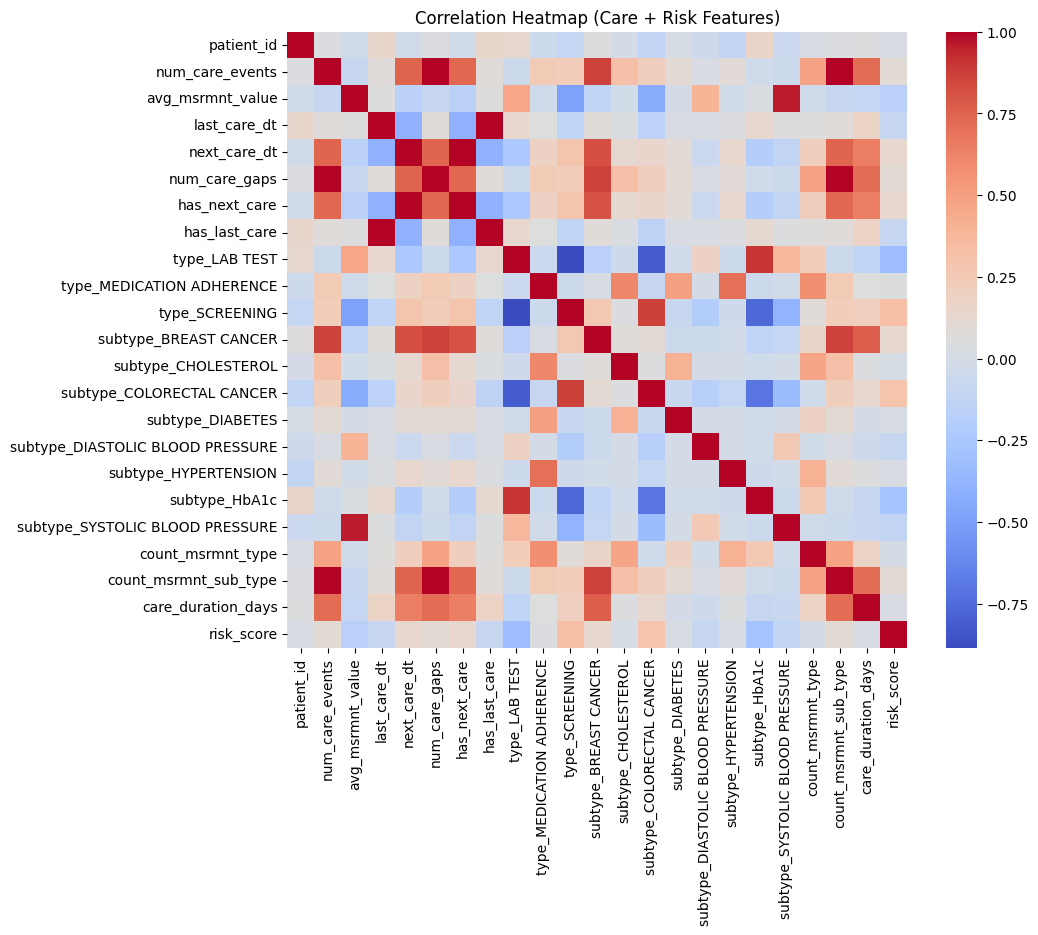

C:\Users\palla\AppData\Local\Temp\ipykernel_3156\67467576.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')


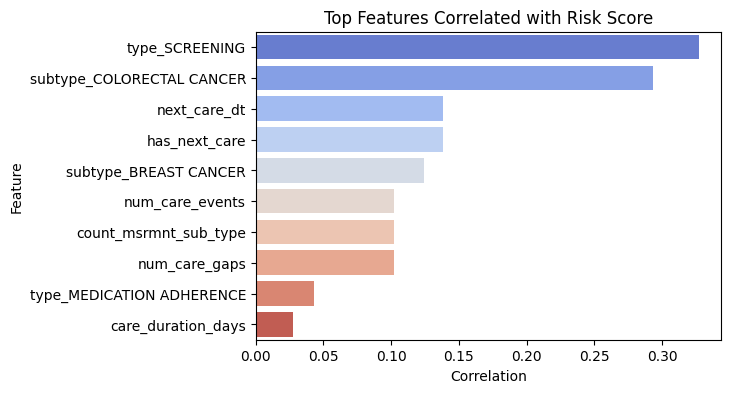

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


care_risk_merged = pd.merge(
    care_final,
    risk_df[['patient_id', 'risk_score']],
    on='patient_id',
    how='inner'
)

print(f"Merged care + risk data shape: {care_risk_merged.shape}")

for col in ['last_care_dt', 'next_care_dt']:
    care_risk_merged[col] = pd.to_datetime(care_risk_merged[col], errors='coerce')
    care_risk_merged[col] = care_risk_merged[col].astype('int64', errors='ignore') // 1e9


corr_matrix = care_risk_merged.corr(numeric_only=True)


target_corr = corr_matrix['risk_score'].sort_values(ascending=False)
print("\nCorrelation with risk_score:")
print(target_corr)


plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap (Care + Risk Features)")
plt.show()


top_corr = target_corr[1:11]  
plt.figure(figsize=(6,4))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='coolwarm')
plt.title("Top Features Correlated with Risk Score")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.show()


In [4]:
care_final.to_csv("risk_care.csv", index=False)
care_risk_merged.to_csv("merged_care_risk.csv", index=False)

In [5]:
care_risk_merged.isnull().sum()

patient_id                          0
num_care_events                     0
avg_msrmnt_value                    0
last_care_dt                        0
next_care_dt                        0
num_care_gaps                       0
has_next_care                       0
has_last_care                       0
type_LAB TEST                       0
type_MEDICATION ADHERENCE           0
type_SCREENING                      0
subtype_BREAST CANCER               0
subtype_CHOLESTEROL                 0
subtype_COLORECTAL CANCER           0
subtype_DIABETES                    0
subtype_DIASTOLIC BLOOD PRESSURE    0
subtype_HYPERTENSION                0
subtype_HbA1c                       0
subtype_SYSTOLIC BLOOD PRESSURE     0
count_msrmnt_type                   0
count_msrmnt_sub_type               0
care_duration_days                  0
risk_score                          0
dtype: int64

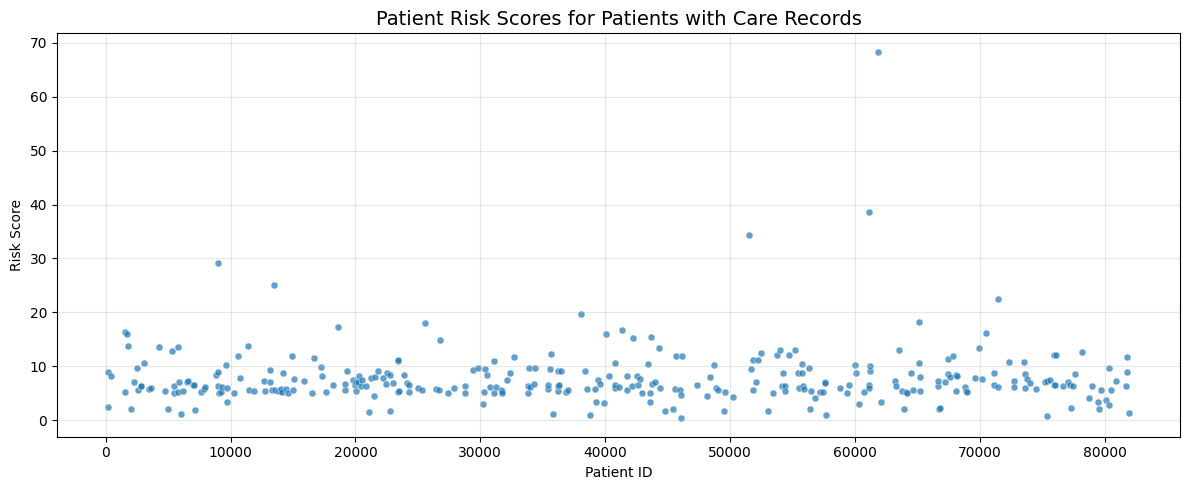

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns


plot_df = care_risk_merged.sort_values('patient_id')

plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=plot_df,
    x='patient_id',
    y='risk_score',
    s=25,
    alpha=0.7
)
plt.title('Patient Risk Scores for Patients with Care Records', fontsize=14)
plt.xlabel('Patient ID')
plt.ylabel('Risk Score')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [8]:
# Patients who have care records
patients_with_care = set(care_df['patient_id'].unique())

# Add flag to risk_df
risk_df['has_care_record'] = risk_df['patient_id'].isin(patients_with_care).astype(int)


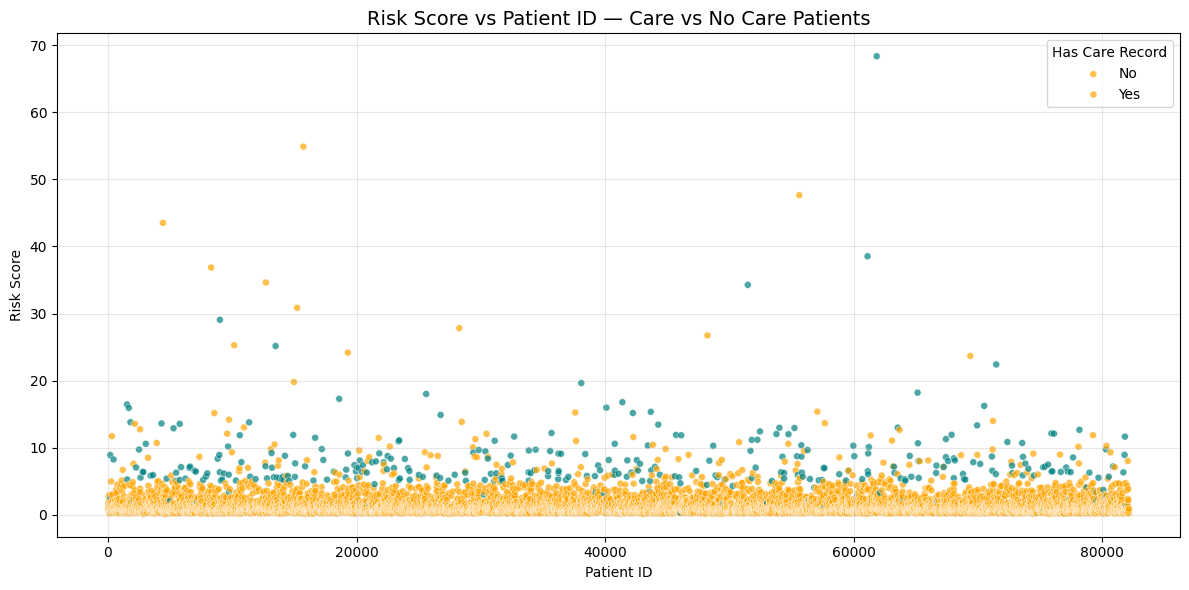

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_df = risk_df.sort_values('patient_id')

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=plot_df,
    x='patient_id',
    y='risk_score',
    hue='has_care_record',
    palette={1: 'teal', 0: 'orange'},
    alpha=0.7,
    s=25
)

plt.title("Risk Score vs Patient ID — Care vs No Care Patients", fontsize=14)
plt.xlabel("Patient ID")
plt.ylabel("Risk Score")
plt.legend(title="Has Care Record", labels=["No", "Yes"])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
